### NETWORK CENTRALITY EFFECTS IN PEER TO PEER LENDING

#### 1. DATA COLLECTION

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


 1. Loading the Lending Club Dataset

In [3]:
# Load the dataset (assuming it's already uploaded to Kaggle)
df = pd.read_csv('/kaggle/input/lendingclubdatasett/new_file_5000.csv')  # Adjust the path as needed

#### 2. DATA PREPROCESSING
1. Selecting Relevant Numeric Columns for Distance Calculation

In [5]:
# Selecting relevant numeric columns and categorial columns for distance calculation
numeric_cols = ['fico_range_low', 'total_acc', 'annual_inc', 'int_rate', 'loan_amnt']
categorical_columns = ['issue_d', 'sub_grade', 'term', 'home_ownership', 'purpose',
                       'application_type', 'verification_status', 'addr_state', 'emp_length']

2. Filtering Rows with Missing Values in Selected Columns

In [6]:
# Filter out rows with missing values in selected columns
df_clean = df[numeric_cols + ['loan_status']].dropna()


In [7]:
# Display the first few rows of the dataset
df_clean.head()

fico_range_low  total_acc  annual_inc  int_rate  loan_amnt  loan_status
0           830.0       13.0    105682.0      7.99    15000.0          1.0
1           660.0       25.0     68000.0     11.49     5000.0          1.0
2           660.0       17.0     75000.0     17.99     8000.0          1.0
3           740.0       36.0    114000.0      5.32    16000.0          1.0
4           680.0       14.0     47000.0     14.49    14000.0          0.0

#### 3. ADJACENCY MATRIX CONSTRUCTION

In this step, we calculate the Euclidean distance matrix between the selected numeric features of the loans. This matrix serves as the adjacency matrix, where each entry represents the distance between two loans, acting as edge weights for the network graph.

In [8]:
# Compute the Euclidean distance matrix between loans (this will act as the adjacency matrix)
distance_matrix = euclidean_distances(df_clean[numeric_cols])

In [9]:
# Convert the distance matrix into an adjacency matrix using exponential decay
adjacency_matrix = np.exp(-distance_matrix)

In [10]:
# Display the adjacency matrix as a DataFrame
adj_matrix_df = pd.DataFrame(adjacency_matrix, index=df_clean.index, columns=df_clean.index)
print(adj_matrix_df)

      0     1     2     3     4     5     6     7     8     9     ...  4990  \
0      1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4996   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4997   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      4991  4992  4993  4994  4995  4996  4997  499

1. Creating a Graph from the Distance Matrix

In [11]:
# Create a graph from the distance matrix
G = nx.Graph()

2. Adding Nodes with Loan Status to the Graph

In [12]:
# Add nodes with their loan status (whether accepted or rejected)
for i in range(df_clean.shape[0]):
    G.add_node(i, loan_status=df_clean.iloc[i]['loan_status'])

3. Adding Weighted Edges to the Graph Based on the Distance Matrix

In [14]:
# Add weighted edges to the graph based on the distance matrix
for i in range(len(distance_matrix)):
    for j in range(i + 1, len(distance_matrix)):
        G.add_edge(i, j, weight=distance_matrix[i, j])


#### 4. MINIMUM SPANNING TREE CONSTRUCTION

1. Computing the Minimum Spanning Tree (MST) from the Graph

In [15]:
# Compute the Minimum Spanning Tree (MST) from the graph
mst = nx.minimum_spanning_tree(G)


2. Defining Color Mapping Based on Loan Status

In [16]:
# Define color mapping based on loan status (0: rejected, 1: accepted)
node_colors = ['green' if df_clean.iloc[i]['loan_status'] == 1 else 'red' for i in mst.nodes()]


3. Plotting the Minimum Spanning Tree (MST) with Colors

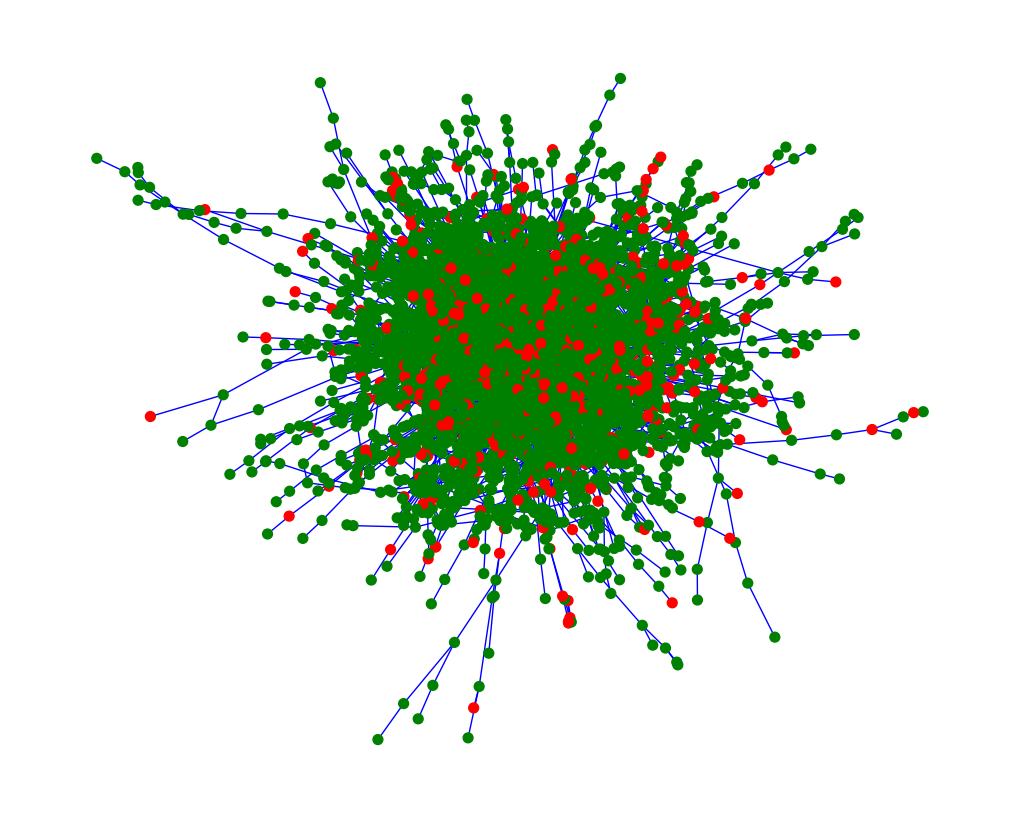

In [17]:
# Plot the MST with colors
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(mst)  # Positioning the nodes for visualization
nx.draw(mst, pos, with_labels=False, node_color=node_colors, edge_color='blue', node_size=50, width=1)

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
def gower_distance(X, numerical_columns, categorical_columns):
    """
    Compute the Gower distance matrix for the given dataframe, considering numerical and categorical features.
    """
    # Step 1: Scale numerical features to [0, 1]
    scaler = MinMaxScaler()
    X_num_scaled = scaler.fit_transform(X[numerical_columns])

    # Step 2: Calculate binary distance for categorical features
    X_cat = X[categorical_columns].astype(str).to_numpy()  # Convert to string to avoid comparison issues
    n_rows, n_cols = X_cat.shape
    cat_distances = np.zeros((n_rows, n_rows, n_cols))

    for col in range(n_cols):
        cat_distances[:, :, col] = (X_cat[:, None, col] != X_cat[None, :, col]).astype(int)

    # Step 3: Average over the columns for categorical features to get categorical distance
    gower_cat_dist = np.mean(cat_distances, axis=2)

    # Step 4: Compute pairwise Manhattan distance for numerical features
    pairwise_diff = np.abs(X_num_scaled[:, np.newaxis, :] - X_num_scaled[np.newaxis, :, :])

    # Step 5: Average over the columns for numerical features to get numerical distance
    gower_num_dist = np.mean(pairwise_diff, axis=2)

    # Step 6: Combine numerical and categorical distances
    gower_dist = (gower_num_dist + gower_cat_dist) / 2.0

    return gower_dist


In [20]:
# Calculate the Gower distance matrix
gower_distance_matrix = gower_distance(df, numeric_cols, categorical_columns)

In [21]:
# Step 7: Convert Gower's distance matrix into an adjacency matrix using exponential decay
gower_adjacency_matrix = np.exp(-gower_distance_matrix)

In [22]:
# Step 8: Create a graph from the Gower adjacency matrix
G_gower = nx.Graph()

In [23]:
# Add nodes with loan status
for i in range(df.shape[0]):
    G_gower.add_node(i, loan_status=df.iloc[i]['loan_status'])

In [24]:
# Add weighted edges based on the Gower distance matrix
for i in range(len(gower_distance_matrix)):
    for j in range(i + 1, len(gower_distance_matrix)):
        G_gower.add_edge(i, j, weight=gower_distance_matrix[i, j])

In [25]:
# Step 9: Compute the Minimum Spanning Tree (MST) from the Gower-based graph
mst_gower = nx.minimum_spanning_tree(G_gower)

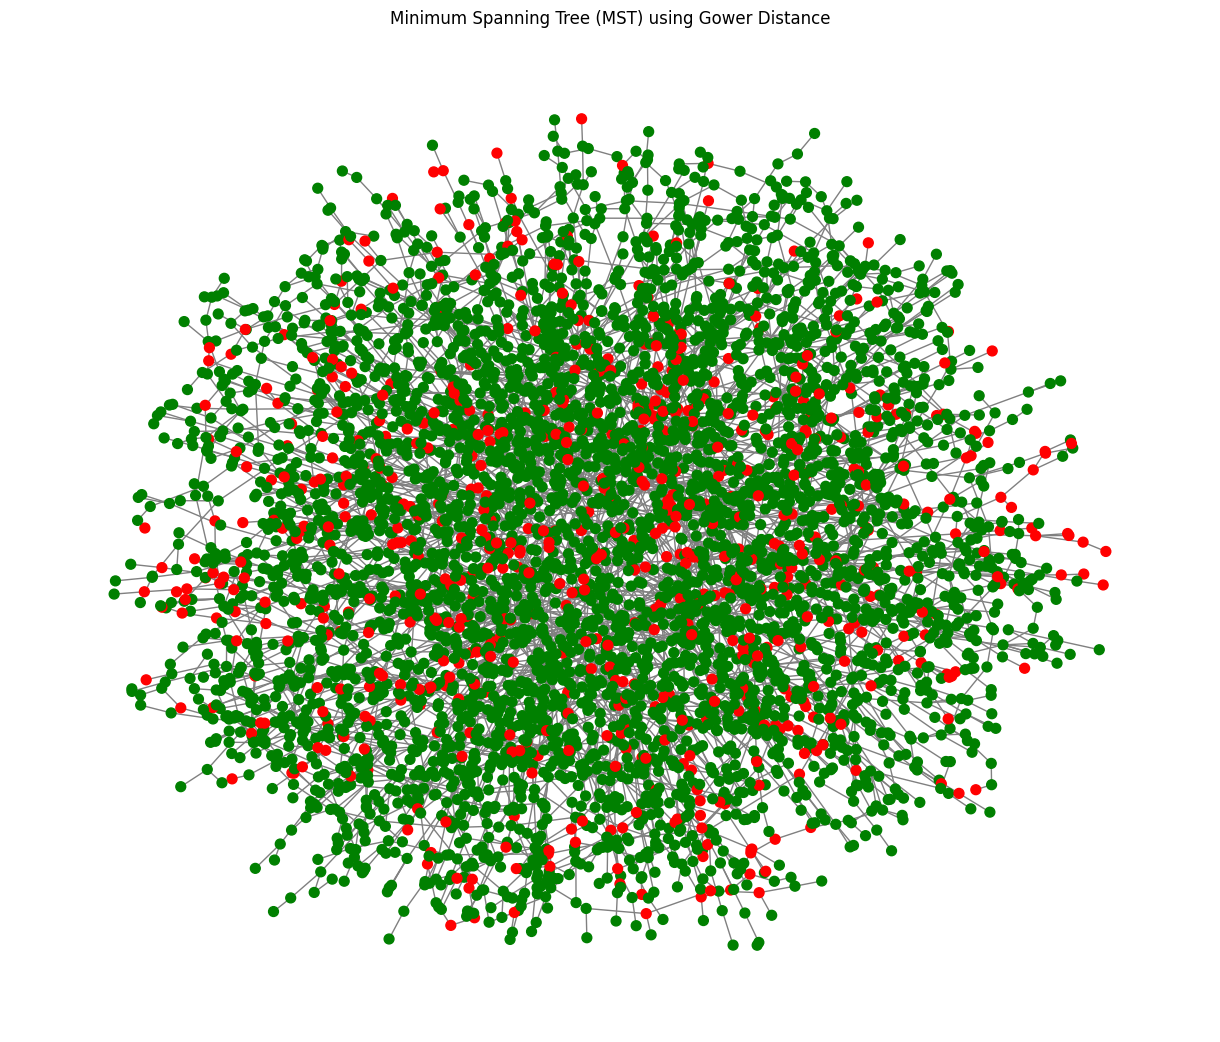

In [26]:
# Step 10: Visualize the MST
node_colors_gower = ['green' if df.iloc[i]['loan_status'] == 1 else 'red' for i in mst_gower.nodes()]
plt.figure(figsize=(12, 10))
pos_gower = nx.spring_layout(mst_gower)  # Positioning for the nodes
nx.draw(mst_gower, pos_gower, with_labels=False, node_color=node_colors_gower, edge_color='gray', node_size=50, width=1)
plt.title('Minimum Spanning Tree (MST) using Gower Distance')
plt.show()

In [27]:
# Optionally, display some metrics for verification
degree_dict = dict(mst_gower.degree())
degree_centrality_dict = nx.degree_centrality(mst_gower)
betweenness_dict = nx.betweenness_centrality(mst_gower, weight='weight')
strength_dict = {node: sum(data['weight'] for _, _, data in mst_gower.edges(node, data=True)) for node in mst_gower.nodes()}
pagerank_dict = nx.pagerank(mst_gower, weight='weight')

In [28]:
# Create a DataFrame to show metrics
metrics_df = pd.DataFrame({
    'Degree': degree_dict,
    'Degree Centrality': degree_centrality_dict,
    'Betweenness Centrality': betweenness_dict,
    'Strength': strength_dict,
    'PageRank': pagerank_dict
})

In [29]:
print(metrics_df.head(20))

    Degree  Degree Centrality  Betweenness Centrality  Strength  PageRank
0        1             0.0002                0.000000  0.153795  0.000131
1        2             0.0004                0.000400  0.234318  0.000233
2        2             0.0004                0.000400  0.204483  0.000218
3        4             0.0008                0.001999  0.491291  0.000437
4        2             0.0004                0.000800  0.164793  0.000220
5        2             0.0004                0.000400  0.213457  0.000217
6        1             0.0002                0.000000  0.109613  0.000124
7        1             0.0002                0.000000  0.071589  0.000093
8        5             0.0010                0.056090  0.430957  0.000381
9        1             0.0002                0.000000  0.092158  0.000125
10       1             0.0002                0.000000  0.076896  0.000092
11       1             0.0002                0.000000  0.134877  0.000131
12       4             0.0008         

In [30]:
# Step 1: Preprocess the dataset
def preprocess_data(df, numerical_columns, categorical_columns):
    # Scale numerical columns
    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    # One-hot encode categorical columns
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    return df

In [31]:
# Preprocess the data
df_processed = preprocess_data(df, numeric_cols, categorical_columns)

In [32]:
# Step 7: Compute the Euclidean distance matrix
distance_matrix = euclidean_distances(df_processed[numeric_cols])

In [33]:
# Step 8: Convert the distance matrix into an adjacency matrix using exponential decay
adjacency_matrix = np.exp(-distance_matrix)

In [34]:
# Step 9: Create a graph from the Euclidean distance matrix
G_euclidean = nx.Graph()

In [35]:
# Add nodes with loan status
for i in range(df.shape[0]):
    G_euclidean.add_node(i, loan_status=df.iloc[i]['loan_status'])

In [36]:
# Add weighted edges based on the Euclidean distance matrix
for i in range(len(distance_matrix)):
    for j in range(i + 1, len(distance_matrix)):
        G_euclidean.add_edge(i, j, weight=distance_matrix[i, j])

In [37]:
# Step 10: Compute the Minimum Spanning Tree (MST) from the Euclidean-based graph
mst_euclidean = nx.minimum_spanning_tree(G_euclidean)

In [38]:
# Define color mapping for loan status in the Euclidean MST (0: rejected, 1: accepted)
node_colors_euclidean = ['green' if df_clean.iloc[i]['loan_status'] == 1 else 'red' for i in mst_euclidean.nodes()]

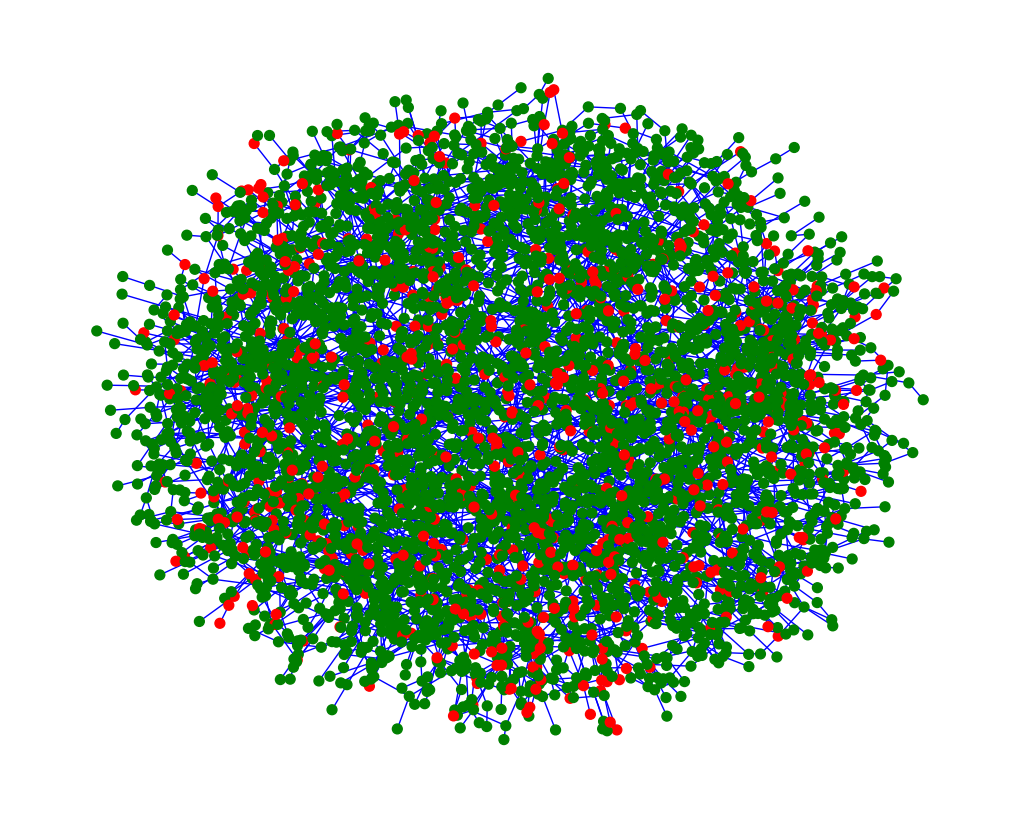

In [40]:
# Plot the Euclidean MST
plt.figure(figsize=(10, 8))
pos_euclidean = nx.spring_layout(mst_euclidean)  # Positioning the nodes for visualization
nx.draw(
    mst_euclidean, 
    pos_euclidean, 
    with_labels=False, 
    node_color=node_colors_euclidean, 
    edge_color='blue', 
    node_size=50, 
    width=1
)

In [41]:
# Step 11: Calculate various metrics for Euclidean
degree_dict_euclidean = dict(mst_euclidean.degree())
degree_centrality_dict_euclidean = nx.degree_centrality(mst_euclidean)
betweenness_dict_euclidean = nx.betweenness_centrality(mst_euclidean, weight='weight')
strength_dict_euclidean = {node: sum(data['weight'] for _, _, data in mst_euclidean.edges(node, data=True)) for node in mst_euclidean.nodes()}
pagerank_dict_euclidean = nx.pagerank(mst_euclidean, weight='weight')

In [42]:
# Create a DataFrame to hold Euclidean metrics for visualization
metrics_df_euclidean = pd.DataFrame({
    'Degree': degree_dict_euclidean,
    'Degree Centrality': degree_centrality_dict_euclidean,
    'Betweenness Centrality': betweenness_dict_euclidean,
    'Strength': strength_dict_euclidean,
    'PageRank': pagerank_dict_euclidean
})

In [43]:
print(metrics_df_euclidean.head(20))

    Degree  Degree Centrality  Betweenness Centrality  Strength  PageRank
0        2             0.0004                0.004392  0.281650  0.000229
1        2             0.0004                0.005587  0.069050  0.000170
2        1             0.0002                0.000000  0.051649  0.000141
3        1             0.0002                0.000000  0.093834  0.000121
4        4             0.0008                0.009171  0.181845  0.000358
5        1             0.0002                0.000000  0.059215  0.000125
6        3             0.0006                0.015093  0.126283  0.000298
7        3             0.0006                0.027640  0.125313  0.000223
8        2             0.0004                0.031113  0.093641  0.000206
9        4             0.0008                0.015915  0.195291  0.000309
10       2             0.0004                0.001200  0.090466  0.000200
11       2             0.0004                0.003196  0.165255  0.000195
12       2             0.0004         

In [44]:
# Check the contents of the metrics DataFrames
print("Metrics DataFrame for Gower:")
print(metrics_df.head())
print("\nMetrics DataFrame for Euclidean:")
print(metrics_df_euclidean.head())

Metrics DataFrame for Gower:
   Degree  Degree Centrality  Betweenness Centrality  Strength  PageRank
0       1             0.0002                0.000000  0.153795  0.000131
1       2             0.0004                0.000400  0.234318  0.000233
2       2             0.0004                0.000400  0.204483  0.000218
3       4             0.0008                0.001999  0.491291  0.000437
4       2             0.0004                0.000800  0.164793  0.000220

Metrics DataFrame for Euclidean:
   Degree  Degree Centrality  Betweenness Centrality  Strength  PageRank
0       2             0.0004                0.004392  0.281650  0.000229
1       2             0.0004                0.005587  0.069050  0.000170
2       1             0.0002                0.000000  0.051649  0.000141
3       1             0.0002                0.000000  0.093834  0.000121
4       4             0.0008                0.009171  0.181845  0.000358


In [45]:
# Define the metrics to calculate statistics for
metrics_to_calculate = ['Degree', 'Degree Centrality', 'Betweenness Centrality', 'Strength', 'PageRank']

In [46]:
# Function to calculate mean, median, min, and max for a given DataFrame
def calculate_statistics(df):
    stats = pd.DataFrame(columns=['Metric', 'Mean', 'Median', 'Min', 'Max'])
    for metric in metrics_to_calculate:
        mean_value = df[metric].mean()
        median_value = df[metric].median()
        min_value = df[metric].min()
        max_value = df[metric].max()
        # Create a DataFrame for the current metric's statistics
        metric_stats = pd.DataFrame({
            'Metric': [metric],
            'Mean': [mean_value],
            'Median': [median_value],
            'Min': [min_value],
            'Max': [max_value]
        })
        # Concatenate the new row with the existing stats DataFrame
        stats = pd.concat([stats, metric_stats], ignore_index=True)
    return stats

In [47]:
# Calculate statistics for Gower metrics
gower_stats = calculate_statistics(metrics_df)
print("Statistics for Gower MST:")
print(gower_stats)

Statistics for Gower MST:
                   Metric      Mean    Median       Min       Max
0                  Degree  1.999600  2.000000         1         9
1       Degree Centrality  0.000400  0.000400    0.0002    0.0018
2  Betweenness Centrality  0.005733  0.000400       0.0  0.635244
3                Strength  0.218568  0.184816  0.012588   1.03183
4                PageRank  0.000200  0.000180  0.000041  0.000797


/tmp/ipykernel_30/3738880145.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats = pd.concat([stats, metric_stats], ignore_index=True)


In [48]:
# Calculate statistics for Euclidean metrics
euclidean_stats = calculate_statistics(metrics_df_euclidean)
print("\nStatistics for Euclidean MST:")
print(euclidean_stats)


Statistics for Euclidean MST:
                   Metric      Mean    Median       Min       Max
0                  Degree  1.999600  2.000000         1         6
1       Degree Centrality  0.000400  0.000400    0.0002    0.0012
2  Betweenness Centrality  0.014495  0.000800       0.0  0.648553
3                Strength  0.122326  0.105370  0.004245  0.944828
4                PageRank  0.000200  0.000191  0.000037  0.000557


/tmp/ipykernel_30/3738880145.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats = pd.concat([stats, metric_stats], ignore_index=True)


In [74]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [77]:
# Load the dataset
df = pd.read_csv('/kaggle/input/lendingclubdatasett/new_file_5000.csv')
numeric_cols = ['fico_range_low', 'total_acc', 'annual_inc', 'int_rate', 'loan_amnt']
categorical_columns = ['issue_d', 'sub_grade', 'term', 'home_ownership', 'purpose',
                       'application_type', 'verification_status', 'addr_state', 'emp_length']
df_clean = df[numeric_cols + categorical_columns + ['loan_status']].dropna()

In [79]:
# Preprocess dataset
def preprocess_data(df, numerical_columns, categorical_columns):
    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    return df

In [81]:
df_processed = preprocess_data(df_clean, numeric_cols, categorical_columns)
X = df_processed.drop('loan_status', axis=1)
y = df_processed['loan_status']

In [83]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:
# Function to calculate metrics for MST
def calculate_metrics(G):
    degree_dict = dict(G.degree())
    degree_centrality_dict = nx.degree_centrality(G)
    betweenness_dict = nx.betweenness_centrality(G, weight='weight')
    strength_dict = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}
    pagerank_dict = nx.pagerank(G, weight='weight')

    metrics_df = pd.DataFrame({
        'Degree': degree_dict,
        'Degree Centrality': degree_centrality_dict,
        'Betweenness Centrality': betweenness_dict,
        'Strength': strength_dict,
        'PageRank': pagerank_dict
    })
    return metrics_df

In [85]:
# Euclidean MST
euclidean_dist_matrix = euclidean_distances(df_clean[numeric_cols])
adjacency_matrix_euclidean = np.exp(-euclidean_dist_matrix)
G_euclidean = nx.Graph()
for i in range(len(euclidean_dist_matrix)):
    for j in range(i + 1, len(euclidean_dist_matrix)):
        G_euclidean.add_edge(i, j, weight=euclidean_dist_matrix[i, j])
mst_euclidean = nx.minimum_spanning_tree(G_euclidean)
metrics_euclidean = calculate_metrics(mst_euclidean)

In [86]:
# Gower MST
def gower_distance(X, numerical_columns, categorical_columns):
    scaler = MinMaxScaler()
    X_num_scaled = scaler.fit_transform(X[numerical_columns])
    X_cat = X[categorical_columns].astype(str).to_numpy()
    n_rows, n_cols = X_cat.shape
    cat_distances = np.zeros((n_rows, n_rows, n_cols))
    for col in range(n_cols):
        cat_distances[:, :, col] = (X_cat[:, None, col] != X_cat[None, :, col]).astype(int)
    gower_cat_dist = np.mean(cat_distances, axis=2)
    pairwise_diff = np.abs(X_num_scaled[:, np.newaxis, :] - X_num_scaled[np.newaxis, :, :])
    gower_num_dist = np.mean(pairwise_diff, axis=2)
    gower_dist = (gower_num_dist + gower_cat_dist) / 2.0
    return gower_dist

In [ ]:
gower_dist_matrix = gower_distance(df_clean, numeric_cols, categorical_columns)
adjacency_matrix_gower = np.exp(-gower_dist_matrix)
G_gower = nx.Graph()
for i in range(len(gower_dist_matrix)):
    for j in range(i + 1, len(gower_dist_matrix)):
        G_gower.add_edge(i, j, weight=gower_dist_matrix[i, j])
mst_gower = nx.minimum_spanning_tree(G_gower)
metrics_gower = calculate_metrics(mst_gower)

In [ ]:
# Combine the metrics with the dataset
df_metrics_euclidean = pd.concat([df_clean.reset_index(drop=True), metrics_euclidean], axis=1)
df_metrics_gower = pd.concat([df_clean.reset_index(drop=True), metrics_gower], axis=1)

In [ ]:
# Train and evaluate models
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)

    return accuracy, precision, recall, f1, auc

In [ ]:
# Without Network
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=0.3, random_state=42)
metrics_base = train_and_evaluate(X_train_base, X_test_base, y_train_base, y_test_base)

In [ ]:
# Network Euclidean MST
X_train_euclidean, X_test_euclidean, y_train_euclidean, y_test_euclidean = train_test_split(
    df_metrics_euclidean.drop(['loan_status'], axis=1), df_metrics_euclidean['loan_status'], 
    test_size=0.3, random_state=42
)
metrics_euclidean_mst = train_and_evaluate(X_train_euclidean, X_test_euclidean, y_train_euclidean, y_test_euclidean)

In [ ]:
# Network Gower MST
X_train_gower, X_test_gower, y_train_gower, y_test_gower = train_test_split(
    df_metrics_gower.drop(['loan_status'], axis=1), df_metrics_gower['loan_status'], 
    test_size=0.3, random_state=42
)
metrics_gower_mst = train_and_evaluate(X_train_gower, X_test_gower, y_train_gower, y_test_gower)

In [ ]:
# Display results
print("Performance Metrics:")
print(f"Without Network - Accuracy: {metrics_base[0]:.2f}, Precision: {metrics_base[1]:.2f}, Recall: {metrics_base[2]:.2f}, F1: {metrics_base[3]:.2f}, AUC: {metrics_base[4]:.2f}")
print(f"Network Euclidean MST - Accuracy: {metrics_euclidean_mst[0]:.2f}, Precision: {metrics_euclidean_mst[1]:.2f}, Recall: {metrics_euclidean_mst[2]:.2f}, F1: {metrics_euclidean_mst[3]:.2f}, AUC: {metrics_euclidean_mst[4]:.2f}")
print(f"Network Gower MST - Accuracy: {metrics_gower_mst[0]:.2f}, Precision: {metrics_gower_mst[1]:.2f}, Recall: {metrics_gower_mst[2]:.2f}, F1: {metrics_gower_mst[3]:.2f}, AUC: {metrics_gower_mst[4]:.2f}")

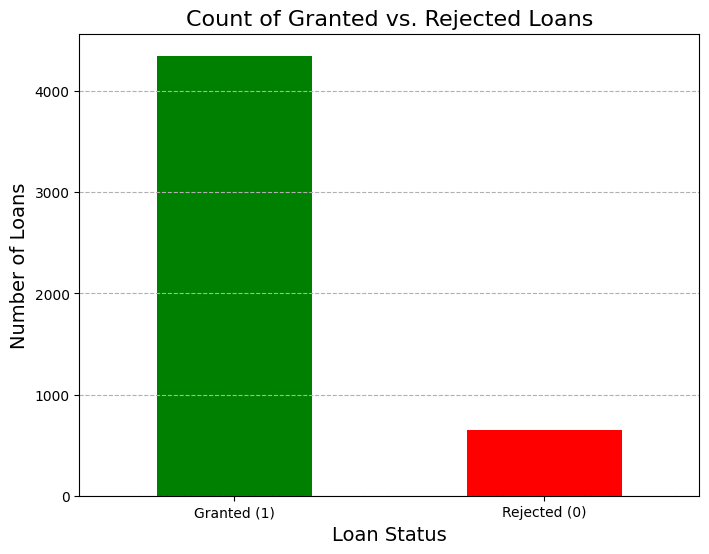

In [49]:
# Count the number of granted (1) and rejected (0) loans
loan_status_counts = df['loan_status'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
loan_status_counts.plot(kind='bar', color=['green', 'red'])

# Adding titles and labels
plt.title('Count of Granted vs. Rejected Loans', fontsize=16)
plt.xlabel('Loan Status', fontsize=14)
plt.ylabel('Number of Loans', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Granted (1)', 'Rejected (0)'], rotation=0)
plt.grid(axis='y', linestyle='--')

# Show the plot for the bar graph
plt.show()

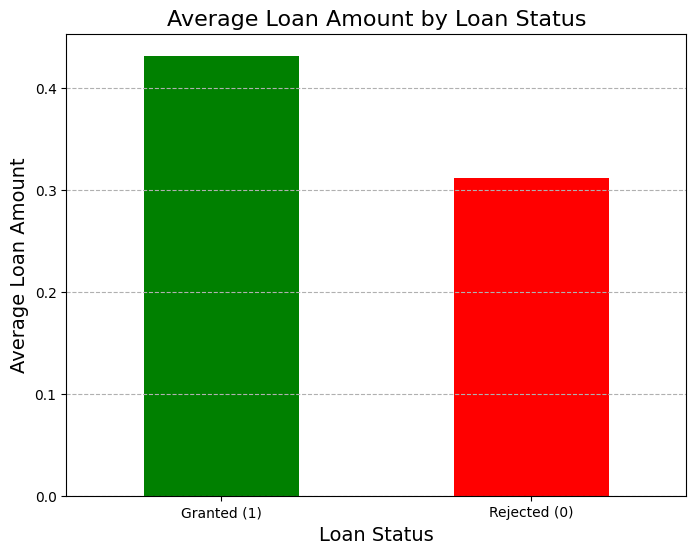

In [50]:
# Calculate average loan amount by loan status
average_loan_amount = df.groupby('loan_status')['loan_amnt'].mean()

# Plotting the bar graph for average loan amount by status
plt.figure(figsize=(8, 6))
average_loan_amount.plot(kind='bar', color=['green', 'red'])

# Adding titles and labels
plt.title('Average Loan Amount by Loan Status', fontsize=16)
plt.xlabel('Loan Status', fontsize=14)
plt.ylabel('Average Loan Amount', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Granted (1)', 'Rejected (0)'], rotation=0)
plt.grid(axis='y', linestyle='--')

# Show the plot for the bar graph
plt.show()